<a href="https://colab.research.google.com/github/hananbahtiti/Hybrid-Intrusion-detection-Systems/blob/main/NetworkPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp /content/eve_encoded.csv /content/drive/MyDrive/hybrid_IDS/dataset/

In [58]:
df = pd.read_csv('/content/drive/MyDrive/hybrid_IDS/dataset/eve_encoded.csv')
df.info()
df.head()
#df['alert'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286150 entries, 0 to 286149
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   proto           286150 non-null  int64  
 1   event_type      286150 non-null  int64  
 2   flow_id         286048 non-null  float64
 3   Date            286150 non-null  int64  
 4   hour            137399 non-null  float64
 5   minute          137399 non-null  float64
 6   second          137399 non-null  float64
 7   pkts_toclient   284361 non-null  float64
 8   bytes_toserver  284361 non-null  float64
 9   bytes_toclient  284361 non-null  float64
 10  tcp_flags       270253 non-null  float64
 11  alerted         286150 non-null  int64  
 12  age             279361 non-null  float64
 13  reason          286150 non-null  int64  
 14  pkts_toserver   284361 non-null  float64
 15  tcp_flags_ts    270253 non-null  float64
 16  state           286150 non-null  int64  
dtypes: float64

,proto,event_type,flow_id,Date,hour,minute,second,pkts_toclient,bytes_toserver,bytes_toclient,tcp_flags,alerted,age,reason,pkts_toserver,tcp_flags_ts,state
0,4,0,NaN,0,17.0,49.0,10.0,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,0
1,4,0,2.558362e+14,0,17.0,49.0,44.0,0.0,62.0,0.0,NaN,0,NaN,0,1.0,NaN,0
2,4,0,2.558362e+14,0,17.0,49.0,44.0,0.0,62.0,0.0,NaN,0,NaN,0,1.0,NaN,0
3,5,8,5.620575e+13,0,17.0,49.0,36.0,NaN,NaN,NaN,NaN,0,NaN,0,NaN,NaN,0
4,4,2,8.582737e+14,0,17.0,48.0,59.0,0.0,60.0,0.0,0.0,1,0.0,2,1.0,0.0,1


In [1]:
import pandas as pd
import numpy as np
import os
import glob
import math
import ast
import time
from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
try:
    from tqdm import tqdm
    TQDM_AVAILABLE = True
except ImportError:
    TQDM_AVAILABLE = False

In [71]:
class Preprocessing:
  def __init__(self):
    pass

  def clean_and_save(self, file_path: str, output_path: str, threshold=80):
    try:
        df = pd.read_csv(file_path)
        total_rows = len(df)
        missing_ratios = (df.isnull().sum() / total_rows) * 100

        columns_to_drop = [col for col, ratio in missing_ratios.items() if ratio > threshold]

        print(f"Columns to drop: {columns_to_drop}")

        df = df.drop(columns=columns_to_drop, axis=1)
        df.to_csv(output_path, index=False)
        return f"Saved cleaned data to {output_path}"
    except Exception as e:
      return f"An error occurred: {e}"


  def columns_drop(self, file_path: str, columns_names: list, output_path: str):
    try:
        df = pd.read_csv(file_path)
        df = df.drop(columns=columns_names, axis=1)  # Drop columns once
        df.to_csv(output_path, index=False)
        return f"Saved cleaned data to {output_path}"
    except Exception as e:
        return f"An error occurred: {e}"


  def data_encoding(self, file_path, columns_names: list):
    encoder = LabelEncoder()
    tqdm.pandas()

    try:
        df = pd.read_csv(file_path)  # قراءة الملف مرة واحدة فقط

        for col in columns_names:
            df.loc[:, col] = df.loc[:, col].fillna("-1").astype(str)

            encoder.fit(df.loc[:, col])

            # تحديث شريط التقدم بحيث يظهر اسم العمود
            with tqdm(total=len(df), desc=f"Encoding '{col}'", unit="rows") as pbar:
                def encoding_function(x):
                    result = encoder.transform([x])[0] if pd.notna(x) else -1
                    pbar.update(1)
                    return result

                df.loc[:, col] = df.loc[:, col].apply(encoding_function)

        output_path = file_path.replace(".csv", "_encoded.csv")
        df.to_csv(output_path, index=False)
        return f"Done. Encoded file saved to: {output_path}"

    except Exception as e:
        return f"An error occurred: {e}"



  def drop_constant_columns(self, file_path, output_path=None):
    try:
        df = pd.read_csv(file_path)
        constant_columns = [col for col in df.columns if df[col].nunique(dropna=True) == 1]
        print(f"Columns with constant value: {constant_columns}")

        df = df.drop(columns=constant_columns)
        if output_path is None:
          output_path = file_path.replace('.csv', '_no_constant.csv')
        df.to_csv(output_path, index=False)

        return f"Saved cleaned file to {output_path}"

    except Exception as e:
      return f"An error occurred: {e}"



  def show_column_types(self, file_path):
    try:
      columns_names = []
      df = pd.read_csv(file_path)
      [columns_names.append(col)  for col in df.columns if df[col].dtype == 'object']

      return columns_names
    except Exception as e:
      return f"An error occurred: {e}"




  @staticmethod
  def expand_dict_columns( file_path, column_names: list, output_file_path: str = None):
      try:
          df = pd.read_csv(file_path)

          all_keys = set()

          # Step 1: Extract all keys
          def extract_keys(value):
              if pd.notna(value):
                  try:
                      return ast.literal_eval(value).keys()
                  except (SyntaxError, ValueError):
                      return []
              return []

          print("🔍 Extracting all keys...")

          for column_name in column_names:
              if column_name in df.columns:
                  all_keys.update(df[column_name].apply(extract_keys).explode().dropna().unique())

          print(f"✅ Extracted {len(all_keys)} unique keys.")

          # Step 2: Create new columns and fill values
          if TQDM_AVAILABLE:
              progress_bar = tqdm(all_keys, desc="🚀 Expanding values", ncols=80)
          else:
              progress_bar = all_keys

          for idx, key in enumerate(progress_bar):
              df[key] = np.nan
              for column_name in column_names:
                  if column_name in df.columns:
                      df[key] = df[key].combine_first(
                          df[column_name].apply(lambda x: Preprocessing.expand_dict_column(x, key))
                      )

              # Print manual progress if tqdm is not available
              if not TQDM_AVAILABLE and idx % max(1, len(all_keys)//10) == 0:
                  print(f"📈 Progress: {idx}/{len(all_keys)} keys expanded...")

          # Step 3: Drop original dictionary columns
          df = df.drop(columns=column_names, axis=1)

          # Step 4: Save the new file
          output_file_path = output_file_path or file_path.replace(".csv", "_expanded.csv")
          df.to_csv(output_file_path, index=False)

          return f"✅ Columns expanded and file saved successfully at: {output_file_path}"

      except Exception as e:
          return f"❌ An error occurred: {e}"

  @staticmethod
  def expand_dict_column( value, column_name):
      if pd.notna(value):
          try:
              dictionary = ast.literal_eval(value)
              return dictionary.get(column_name, np.nan)
          except (SyntaxError, ValueError):
              return np.nan
      return np.nan


  def get_corr(self, file, column: str, threshold=0.05):
    try:
      df = pd.read_csv(file)

      corr = df.corr(method='pearson')[column]
      corr_series = pd.Series(dict(corr.items()))
      values = [(value, index ) for value, index in corr_series.sort_values().items() if abs(index) >= threshold or pd.isna(index) ]
      return values
    except Exception as e:
          return f"❌ An error occurred: {e}"



  def smart_impute_and_save(self, input_file, output_file):
    """
    This method automatically fills missing values based on missing ratios,
    then saves the cleaned data to a new CSV file.
    """
    try:
        start_time = time.time()  # Start timing ⏱️
        # Load the data
        df = pd.read_csv(input_file)

        # Get columns to impute based on correlation with 'event_type'
        cols_to_impute = self.get_corr(input_file, column='event_type')  # Use self.get_corr if inside a class
        cols_to_impute = [value for value, index in cols_to_impute]  # Extract column names only
        df = df[cols_to_impute]

        # Remove duplicate columns (optional)
        df = df.loc[:, ~df.columns.duplicated()]

        # Build the feature set
        features = df.copy()

        # Calculate missing value ratios
        missing_ratio = features.isna().mean()
        print("📊 Missing value ratio per column:\n", missing_ratio)

        # Smart imputation
        for col in tqdm(cols_to_impute, desc="Imputing columns", unit="column"):
            if col not in df.columns:
                continue  # Skip if the column was dropped or doesn't exist

            ratio = missing_ratio[col]
            print(f"\n=== Processing column: {col} (Missing {ratio:.2%}) ===")

            if ratio > 0.90:
                print(f"⚠️  Column {col} has too many missing values (>90%). Dropping it...")
                df.drop(columns=[col], inplace=True)

            elif ratio < 0.3:
                print(f"🛠️  Using Iterative Imputer for {col}...")
                imputer = IterativeImputer(max_iter=10, random_state=0)
                temp_data = features[[col]]
                # Using IterativeImputer
                imputed_data = imputer.fit_transform(temp_data)
                df[col] = imputed_data[:, 0]

            else:
                print(f"🔍 Using KNN Imputer for {col}...")
                imputer = KNNImputer(n_neighbors=5)
                temp_data = features[[col]]
                # Using KNNImputer
                imputed_data = imputer.fit_transform(temp_data)
                df[col] = imputed_data[:, 0]

        # Save the cleaned data
        df.to_csv(output_file, index=False)
        print(f"\n✅ Successfully completed missing value filling and saved to {output_file}.")

        end_time = time.time()  # End timing ⏱️
        elapsed_time = end_time - start_time
        print(f"⏱️ Total execution time: {elapsed_time:.2f} seconds")

        return df

    except Exception as e:
        return f"❌ An error occurred: {e}"



a = Preprocessing()
#a.data_encoding('/content/drive/MyDrive/hybrid_IDS/dataset/eve.csv',
#                column_number=19)

#a.clean_and_save(file_path='/content/eve_del_expanded.csv',
 #                output_path='/content/eve_tag.csv', threshold=80)
#a.expand_dict_columns( file_path='/content/eve_del.csv',
 #                    column_names=['tcp' , 'flow'])
#a.drop_constant_columns(file_path='/content/eve_tag.csv')

#c= a.show_column_types( file_path='/content/eve.csv')
#a.data_encoding(file_path='/content/eve.csv',
 #              columns_names=c)
v=a.get_corr(file= '/content/drive/MyDrive/hybrid_IDS/dataset/eve_encoded.csv',
           column='event_type', threshold=0.05)
#a.smart_impute_and_save( input_file='/content/drive/MyDrive/hybrid_IDS/dataset/eve_encoded.csv',
 #                       output_file='/content/eve_output.csv')

In [79]:
df = pd.read_csv('/content/final_nan9.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286150 entries, 0 to 286149
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   bytes_toserver  286150 non-null  float64
 1   pkts_toserver   286150 non-null  float64
 2   alerted         286150 non-null  int64  
 3   state           286150 non-null  int64  
 4   reason          286150 non-null  int64  
 5   event_type      286150 non-null  int64  
 6   tcp_flags       286150 non-null  float64
 7   age             286150 non-null  float64
 8   tcp_flags_ts    286150 non-null  float64
dtypes: float64(5), int64(4)
memory usage: 19.6 MB


,bytes_toserver,pkts_toserver,alerted,state,reason,event_type,tcp_flags,age,tcp_flags_ts
0,111.6,1.8,0,0,0,0,6.0,0.0,6.0
1,62.0,1.0,0,0,0,0,6.0,0.0,6.0
2,62.0,1.0,0,0,0,0,6.0,0.0,6.0
3,318.6,1.0,0,0,0,8,6.0,0.0,6.0
4,60.0,1.0,1,1,2,2,0.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from tqdm import tqdm

def get_corr(file, column: str, threshold=0.05):
    try:
        df = pd.read_csv(file)
        corr = df.corr(method='pearson')[column]
        corr_series = pd.Series(dict(corr.items()))
        values = [(value, index ) for value, index in corr_series.sort_values().items() if abs(index) >= threshold or pd.isna(index) ]
        return values
    except Exception as e:
        return f"❌ An error occurred: {e}"

def calculate_rmse(original_data, imputed_data):
    """Calculate RMSE between the original and imputed data"""
    return np.sqrt(mean_squared_error(original_data, imputed_data))

def plot_comparison(original_data, imputed_data):
    """Plot Scatter plot and Histogram for comparison"""

    plt.figure(figsize=(14, 6))

    # Scatter Plot
    plt.subplot(1, 2, 1)
    plt.scatter(original_data, imputed_data, alpha=0.5)
    plt.title('Scatter Plot: Original vs Imputed')
    plt.xlabel('Original Data')
    plt.ylabel('Imputed Data')

    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist([original_data, imputed_data], label=['Original', 'Imputed'], bins=30, alpha=0.7)
    plt.title('Histogram: Original vs Imputed')
    plt.xlabel('Data Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

def manual_grid_search_knn(temp_data, original_col, neighbors_list=[5, 10, 15]):
    """Manually search for best n_neighbors in KNNImputer based on RMSE."""
    best_rmse = float('inf')
    best_k = None
    best_imputed = None

    for k in neighbors_list:
        imputer = KNNImputer(n_neighbors=k)
        imputed_data = imputer.fit_transform(temp_data)
        imputed_col = imputed_data[:, -1]

        mask = ~np.isnan(original_col)
        rmse = calculate_rmse(original_col[mask], imputed_col[mask])

        print(f"🔍 n_neighbors={k} → RMSE = {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_k = k
            best_imputed = imputed_col

    print(f"✅ Best KNNImputer n_neighbors={best_k} with RMSE={best_rmse:.4f}")
    return best_imputed, best_k

def manual_grid_search_iterative(temp_data, original_col, iter_values=[10, 50, 100]):
    """Manually search for best max_iter in IterativeImputer based on RMSE."""
    best_rmse = float('inf')
    best_iter = None
    best_imputed = None

    for i in iter_values:
        imputer = IterativeImputer(max_iter=i, random_state=0)
        imputed_data = imputer.fit_transform(temp_data)
        imputed_col = imputed_data[:, -1]

        mask = ~np.isnan(original_col)
        rmse = calculate_rmse(original_col[mask], imputed_col[mask])

        print(f"🔍 max_iter={i} → RMSE = {rmse:.4f}")

        if rmse < best_rmse:
            best_rmse = rmse
            best_iter = i
            best_imputed = imputed_col

    print(f"✅ Best IterativeImputer max_iter={best_iter} with RMSE={best_rmse:.4f}")
    return best_imputed, best_iter

def smart_impute_and_save(input_file, output_file, knn_threshold=0.3, drop_threshold=0.8):
    """
    Impute missing values using smart techniques, calculate RMSE and plot comparison with manual Grid Search.
    """
    try:
        df = pd.read_csv(input_file)
        df = df.apply(pd.to_numeric, errors='coerce')

        corr = get_corr(input_file, column='event_type')
        cols_to_impute = [value for value, index in corr]
        df = df[cols_to_impute]

        missing_ratio = df.isna().mean()

        notnan_cols = [col for col, ratio in missing_ratio.items() if ratio == 0.0]
        cols_to_impute = [col for col, ratio in missing_ratio.items() if ratio > 0.0]

        print("📊 Missing value ratios:")
        print(missing_ratio[missing_ratio > 0])

        features = df.copy()
        original_data_dict = {}

        for col in tqdm(cols_to_impute, desc="🧠 Imputing columns", ncols=100):
            ratio = missing_ratio[col]

            if ratio > drop_threshold:
                print(f"⚠️ Dropping column '{col}' due to high missing ratio ({ratio:.2%})")
                df.drop(columns=[col], inplace=True)
                continue

            temp_cols = notnan_cols + [col]
            temp_data = features[temp_cols].copy()
            original_col = features[col].values

            if ratio > knn_threshold:
                best_imputed, best_iter = manual_grid_search_iterative(temp_data, original_col)
            else:
                best_imputed, best_k = manual_grid_search_knn(temp_data, original_col)

            df[col] = best_imputed
            original_data_dict[col] = {
                'original': features[col].dropna().values,
                'imputed': best_imputed[~np.isnan(features[col].values)]
            }

        df.to_csv(output_file, index=False)
        print(f"\n✅ File saved successfully to: {output_file}")

        for col, data in original_data_dict.items():
            original_data = data['original']
            imputed_data = data['imputed']

            rmse_value = calculate_rmse(original_data, imputed_data)
            print(f"📈 RMSE for column '{col}': {rmse_value:.4f}")

            plot_comparison(original_data, imputed_data)

    except Exception as e:
        print(f"❌ An error occurred: {e}")



# تنفيذ الدالة
smart_impute_and_save(
    input_file='/content/drive/MyDrive/hybrid_IDS/dataset/eve_encoded.csv',
    output_file='/content/final.csv'
)


📊 Missing value ratios:
bytes_toserver    0.006252
pkts_toserver     0.006252
tcp_flags         0.055555
age               0.023725
tcp_flags_ts      0.055555
dtype: float64


🧠 Imputing columns:   0%|                                                    | 0/5 [00:00<?, ?it/s]

📊 Missing value ratios:
bytes_toserver    0.006252
pkts_toserver     0.006252
tcp_flags         0.055555
age               0.023725
tcp_flags_ts      0.055555
dtype: float64


🧠 Imputing columns:   0%|                                                    | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best KNNImputer parameters for column 'bytes_toserver': {'n_neighbors': 3}


🧠 Imputing columns:  20%|████████▊                                   | 1/5 [00:38<02:34, 38.69s/it]/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best KNNImputer parameters for column 'pkts_toserver': {'n_neighbors': 3}


🧠 Imputing columns:  40%|█████████████████▌                          | 2/5 [01:05<01:35, 31.75s/it]/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best KNNImputer parameters for column 'tcp_flags': {'n_neighbors': 3}


🧠 Imputing columns:  60%|█████████████████████████▊                 | 3/5 [04:59<04:08, 124.02s/it]/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best KNNImputer parameters for column 'age': {'n_neighbors': 3}


🧠 Imputing columns:  80%|██████████████████████████████████▍        | 4/5 [06:40<01:55, 115.02s/it]/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Best KNNImputer parameters for column 'tcp_flags_ts': {'n_neighbors': 3}


🧠 Imputing columns: 100%|███████████████████████████████████████████| 5/5 [10:32<00:00, 126.46s/it]



✅ File saved successfully to: /content/final_gridsearch.csv
RMSE for column 'bytes_toserver': 0.0000


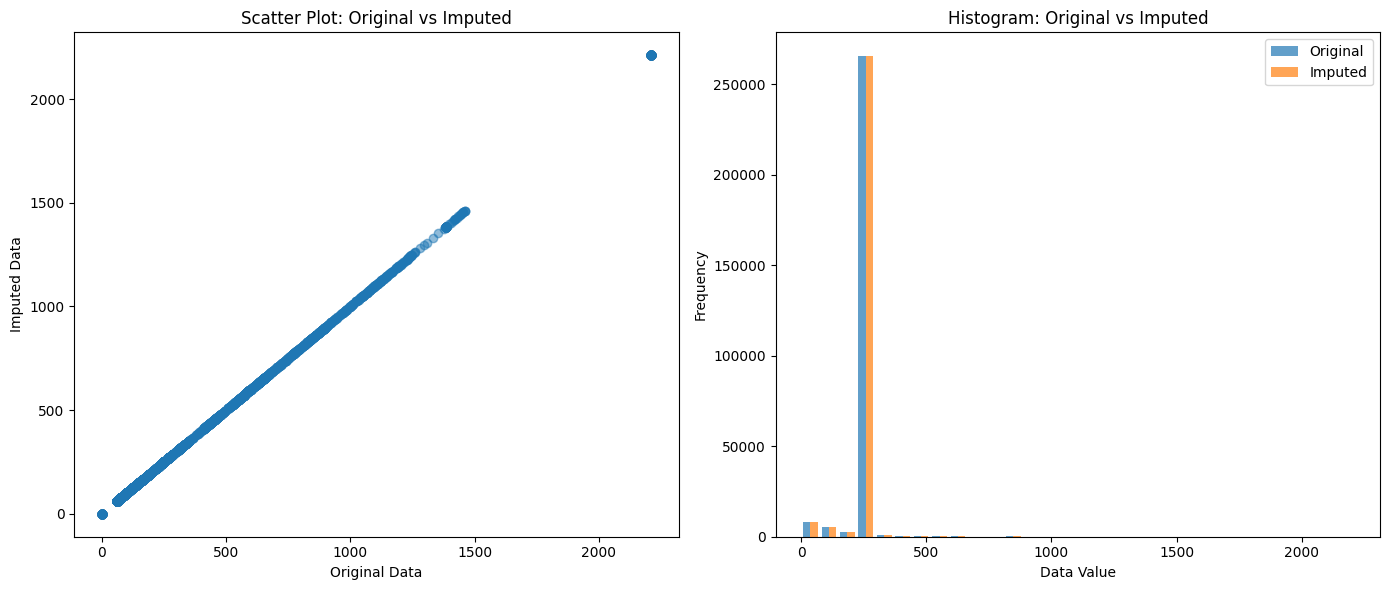

RMSE for column 'pkts_toserver': 0.0000


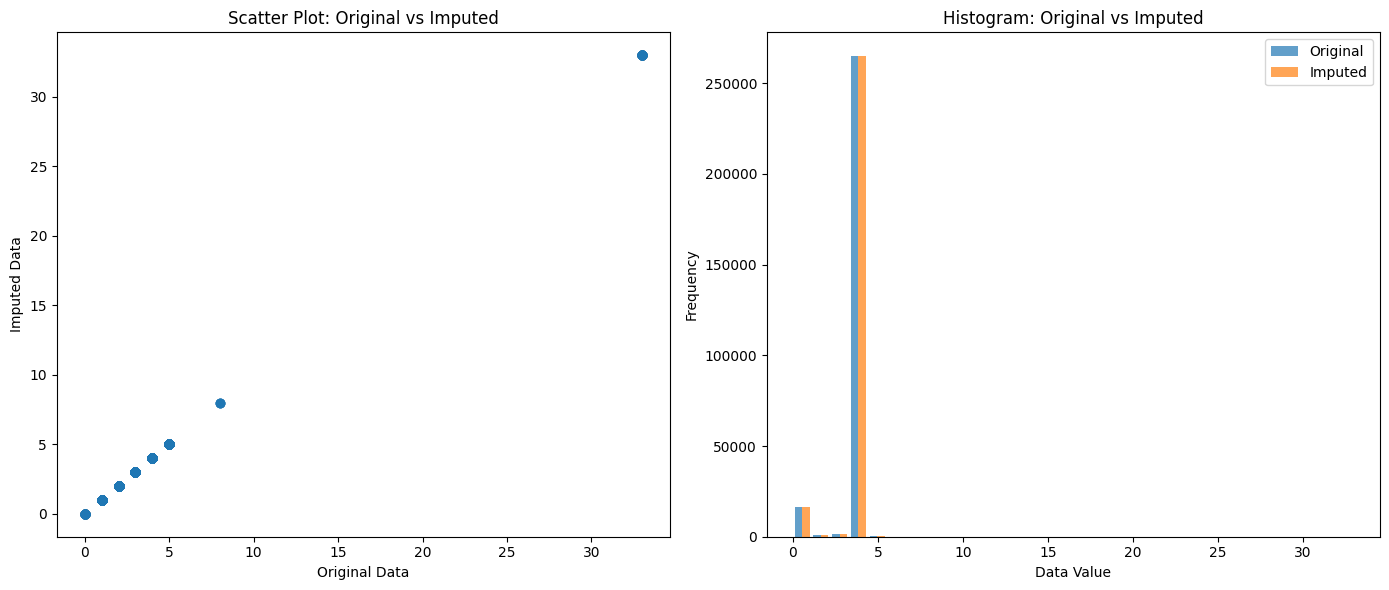

RMSE for column 'tcp_flags': 0.0000


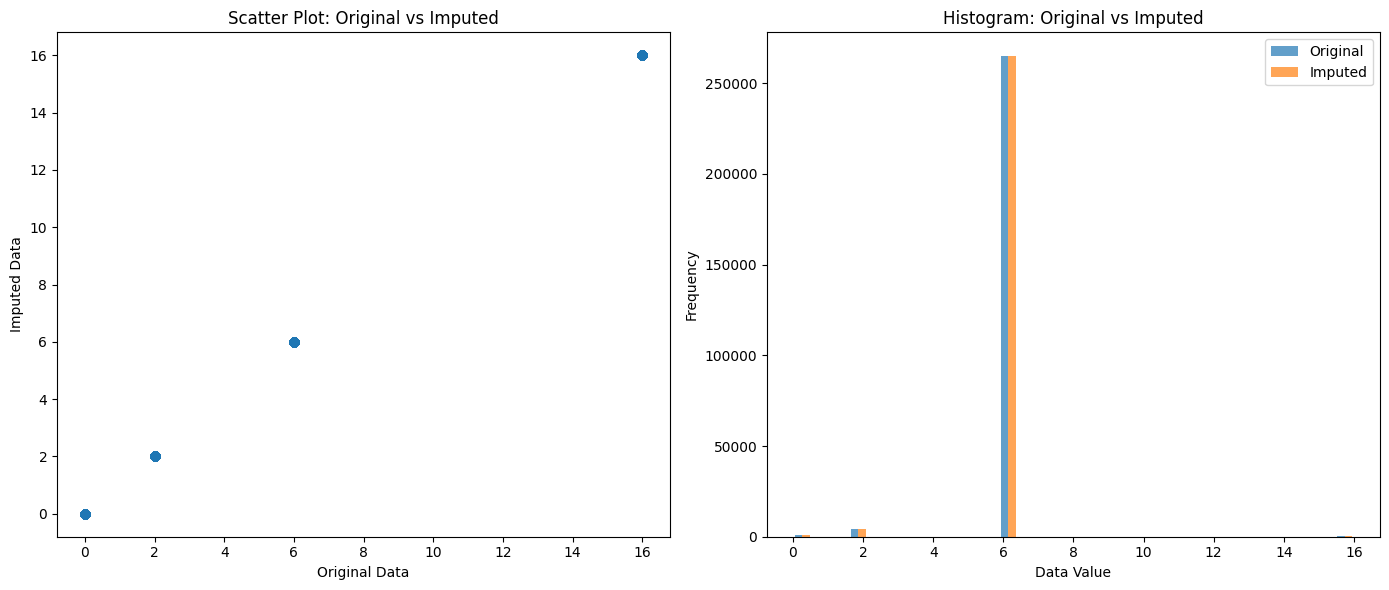

RMSE for column 'age': 0.0000


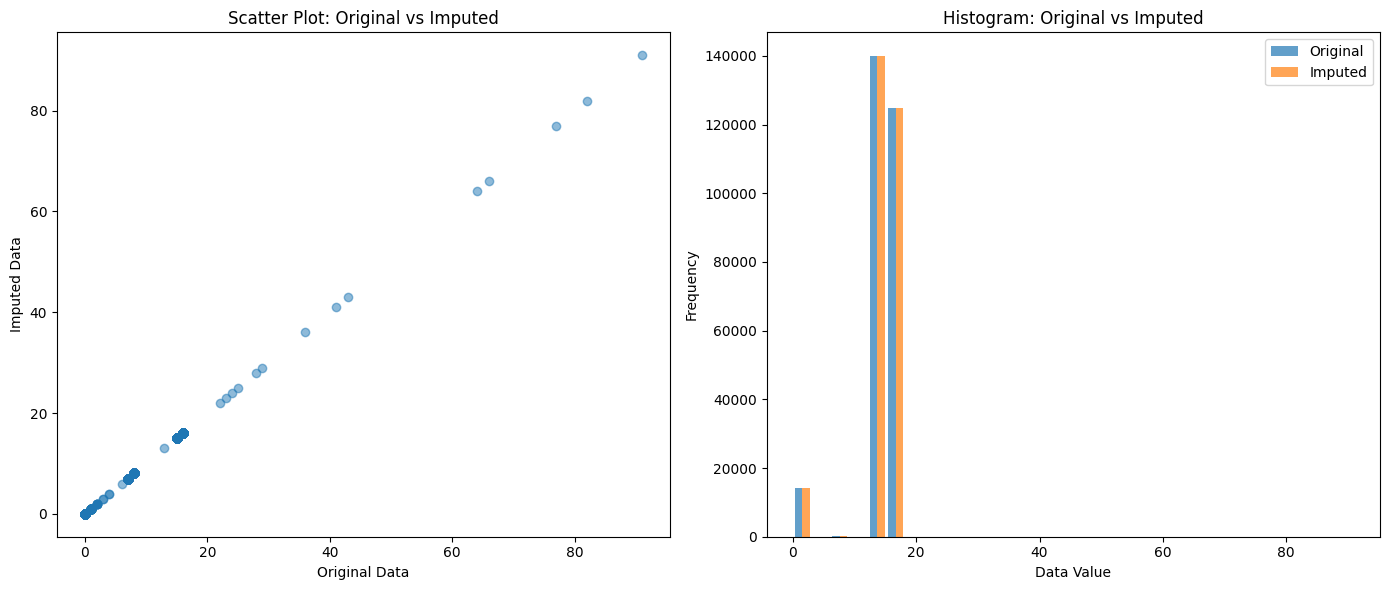

RMSE for column 'tcp_flags_ts': 0.0000


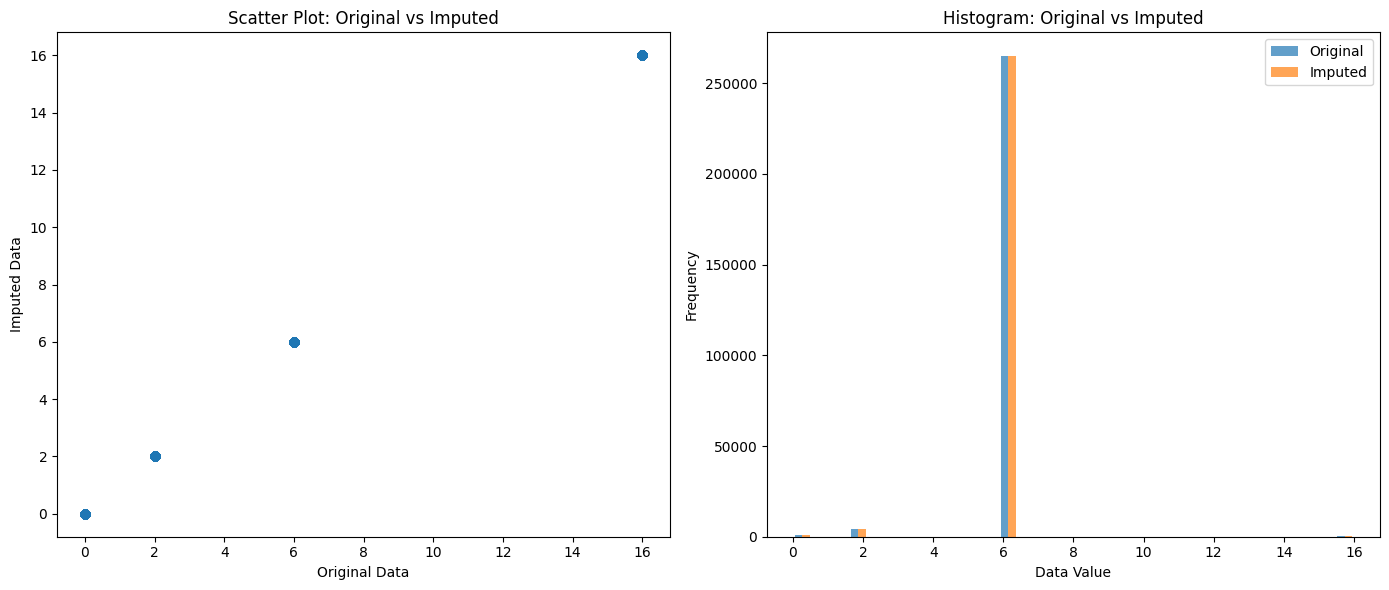

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

def get_corr(file, column: str, threshold=0.05):
    try:
        df = pd.read_csv(file)
        corr = df.corr(method='pearson')[column]
        corr_series = pd.Series(dict(corr.items()))
        values = [(value, index ) for value, index in corr_series.sort_values().items() if abs(index) >= threshold or pd.isna(index) ]
        return values
    except Exception as e:
        return f"❌ An error occurred: {e}"

def calculate_rmse(original_data, imputed_data):
    """Calculate RMSE between the original and imputed data"""
    return np.sqrt(mean_squared_error(original_data, imputed_data))

def plot_comparison(original_data, imputed_data):
    """Plot Scatter plot and Histogram for comparison"""

    # Scatter Plot
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(original_data, imputed_data, alpha=0.5)
    plt.title('Scatter Plot: Original vs Imputed')
    plt.xlabel('Original Data')
    plt.ylabel('Imputed Data')

    # Histogram
    plt.subplot(1, 2, 2)
    plt.hist([original_data, imputed_data], label=['Original', 'Imputed'], bins=30, alpha=0.7)
    plt.title('Histogram: Original vs Imputed')
    plt.xlabel('Data Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

def grid_search_imputation(imputer, param_grid, data):
    """Apply GridSearchCV for selecting the best imputation model"""
    grid_search = GridSearchCV(imputer, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(data)
    return grid_search.best_estimator_, grid_search.best_params_

def smart_impute_and_save(input_file, output_file, knn_threshold=0.3, drop_threshold=0.8):
    """
    Impute missing values using smart techniques, calculate RMSE and plot comparison with GridSearchCV.
    """
    try:
        # Read the full dataset at once
        df = pd.read_csv(input_file)
        df = df.apply(pd.to_numeric, errors='coerce')  # Ensure all data is numeric

        # Get relevant columns based on correlation
        corr = get_corr(input_file, column='event_type')
        cols_to_impute = [value for value, index in corr]  # Extract column names
        df = df[cols_to_impute]

        # Calculate missing value ratios
        missing_ratio = df.isna().mean()

        # Columns without missing values
        notnan_cols = [col for col, ratio in missing_ratio.items() if ratio == 0.0]
        # Columns with missing values
        cols_to_impute = [col for col, ratio in missing_ratio.items() if ratio > 0.0]

        print("📊 Missing value ratios:")
        print(missing_ratio[missing_ratio > 0])

        features = df.copy()

        original_data_dict = {}  # To store original data for RMSE calculation

        # Progress bar for imputation
        for col in tqdm(cols_to_impute, desc="🧠 Imputing columns", ncols=100):
            ratio = missing_ratio[col]

            if ratio > drop_threshold:
                print(f"⚠️ Dropping column '{col}' due to high missing ratio ({ratio:.2%})")
                df.drop(columns=[col], inplace=True)
                continue

            temp_cols = notnan_cols + [col]
            temp_data = features[temp_cols].copy()

            if ratio > knn_threshold:
                # Using GridSearchCV for IterativeImputer
                param_grid = {'max_iter': [10, 50, 100], 'random_state': [0]}
                imputer = IterativeImputer()
                best_imputer, best_params = grid_search_imputation(imputer, param_grid, temp_data)
                print(f"Best IterativeImputer parameters for column '{col}': {best_params}")
            else:
                # Using GridSearchCV for KNNImputer
                param_grid = {'n_neighbors': [3, 5, 10, 15]}
                imputer = KNNImputer()
                best_imputer, best_params = grid_search_imputation(imputer, param_grid, temp_data)
                print(f"Best KNNImputer parameters for column '{col}': {best_params}")

            # Apply the best imputer to fill missing values
            imputed = best_imputer.fit_transform(temp_data)
            df[col] = imputed[:, -1]

            # Store original data (non-NaN) and imputed data for RMSE calculation
            original_data_dict[col] = {
                'original': features[col].dropna().values,
                'imputed': imputed[:, -1][~np.isnan(features[col].values)]
            }

        # Save the cleaned file
        df.to_csv(output_file, index=False)
        print(f"\n✅ File saved successfully to: {output_file}")

        # Calculate RMSE and plot comparison
        for col, data in original_data_dict.items():
            original_data = data['original']
            imputed_data = data['imputed']

            # Calculate RMSE for each column
            rmse_value = calculate_rmse(original_data, imputed_data)
            print(f"RMSE for column '{col}': {rmse_value:.4f}")

            # Plot comparison (scatter and histogram)
            plot_comparison(original_data, imputed_data)

    except Exception as e:
        print(f"❌ An error occurred: {e}")


# تنفيذ الدالة
smart_impute_and_save(
    input_file='/content/drive/MyDrive/hybrid_IDS/dataset/eve_encoded.csv',
    output_file='/content/final_gridsearch.csv'
)


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

file = '/content/drive/MyDrive/hybrid_IDS/dataset/eve_encoded.csv'

# Load the data 286149
chunk_size = 1000000  # عدد الصفوف بالدفعة
chunks = pd.read_csv(file, chunksize=chunk_size)
target_col = 'event_type'

for chunk in chunks:
    # حساب مصفوفة الارتباط فقط بالنسبة للعمود المستهدف (Label)
    corr = chunk.corr(method='pearson')[target_col]
    #corr = chunk.corr(method='pearson')

    # عرض المصفوفة كجدول مرتب
    from IPython.display import display  # لو تعمل داخل jupyter أو colab
    display(corr)

    # عرض المصفوفة الحرارية (heatmap) مع اللون
    plt.figure(figsize=(10, 8), dpi=500)
    sns.heatmap(corr.T, annot=True, fmt=".2f", linewidth=.5, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f"Correlation Matrix with {target_col}")
    plt.show()

    break  # فقط أول دفعة

[proto            -0.009970
 event_type        1.000000
 flow_id           0.000410
 Date             -0.002510
 hour              0.006801
 minute            0.009804
 second            0.010652
 pkts_toclient     0.002509
 bytes_toserver    0.145608
 bytes_toclient    0.002508
 tcp_flags              NaN
 alerted           0.529017
 age                    NaN
 reason            0.619217
 pkts_toserver     0.295515
 tcp_flags_ts           NaN
 state             0.536614
 Name: event_type, dtype: float64]

AttributeError: 'list' object has no attribute 'T'

<Figure size 5000x4000 with 0 Axes>

In [ ]:
class NetworkPreprocessing:
  def __init__(self):
    pass


  def extract_tcp_option(self, option, key):
    for opt in option:
      if opt[0] == key:
        return opt[1]
    return None


  def delete_data(self, file_path):
    df = pd.read_csv(file_path)
    df = df.loc[:, df.nunique() > 1]
    df.to_csv(file_path, index=False)
    return f"Columns containing only one value are deleted..."

  def convert_pcap_csv(self, pcap_file, csv_file):
    try:
      print("Countig packages...")
      with PcapReader(pcap_file) as count_reader:
        total_packets = sum(1 for _ in count_reader)
        print(f"Total number of packages: {total_packets}")

      print("Start converting to csv file...")
      with PcapReader(pcap_file) as packets:
        with open(csv_file, mode='w', newline="") as file:
          writer = csv.writer(file)
          writer.writerow([
              "Packet Number", "Ethernet DST", "Ethernet SRC", "Ethernet Type",
              "IP Version", "IP IHL", "IP TOS", "IP Length", "IP ID", "IP Flags",
              "IP Fragmentation", "IP TTL", "IP Proto", "IP Checksum",
              "IP Src", "IP Dst", "TCP Src Port", "TCP Dst Port", "TCP Seq",
              "TCP Ack", "TCP Data Offset", "TCP Reserved", "TCP Flags",
              "TCP Window", "TCP Checksum", "TCP Urgent Pointer", "TCP Options MSS",
              "TCP Options WScale", "TCP Options NOP","Hexdump"
          ])

          for i, packet in enumerate(tqdm(packets,total=total_packets, desc="Packet processing")):
            if packet.haslayer('Ethernet'):
              eth_dst = packet['Ethernet'].dst
              eth_src = packet['Ethernet'].src
              eth_type = packet['Ethernet'].type
            else:
              eth_dst = eth_src = eth_type = None

            if packet.haslayer('IP'):
              ip_version = packet['IP'].version
              ip_ihl = packet['IP'].ihl
              ip_tos = packet['IP'].tos
              ip_len = packet['IP'].len
              ip_id = packet['IP'].id
              ip_flags = packet['IP'].flags
              ip_frag = packet['IP'].frag
              ip_ttl = packet['IP'].ttl
              ip_proto = packet['IP'].proto
              ip_chksum = packet['IP'].chksum
              ip_src = packet['IP'].src
              ip_dst = packet['IP'].dst
            else:
              ip_version = ip_ihl = ip_tos = ip_len = ip_id = ip_flags = ip_frag = ip_ttl = ip_proto = ip_chksum = ip_src = ip_dst = None

            if packet.haslayer('TCP'):
              tcp_sport = packet['TCP'].sport
              tcp_dport = packet['TCP'].dport
              tcp_seq = packet['TCP'].seq
              tcp_ack = packet['TCP'].ack
              tcp_dataofs = packet['TCP'].dataofs
              tcp_reserved = packet['TCP'].reserved
              tcp_flags = packet['TCP'].flags
              tcp_window = packet['TCP'].window
              tcp_chksum = packet['TCP'].chksum
              tcp_urgptr = packet['TCP'].urgptr
              tcp_options = packet['TCP'].options

              tcp_mss = self.extract_tcp_option(tcp_options, 'MSS')
              tcp_wscale = self.extract_tcp_option(tcp_options, 'WScale')
              tcp_nop_count = self.extract_tcp_option(tcp_options, 'NOP')

            else:
              tcp_sport = tcp_dport = tcp_seq = tcp_ack = tcp_dataofs = tcp_reserved = tcp_flags = tcp_window = tcp_chksum = tcp_urgptr = tcp_mss = tcp_wscale = tcp_nop_count = None

            raw_data = packet.original.hex()
            writer.writerow([
                i + 1, eth_dst, eth_src, eth_type,
                  ip_version, ip_ihl, ip_tos, ip_len, ip_id, ip_flags,
                  ip_frag, ip_ttl, ip_proto, ip_chksum,
                  ip_src, ip_dst, tcp_sport, tcp_dport, tcp_seq,
                  tcp_ack, tcp_dataofs, tcp_reserved, tcp_flags,
                  tcp_window, tcp_chksum, tcp_urgptr, tcp_mss, tcp_wscale, tcp_nop_count,
                  raw_data
            ])

      return f"The file has been converted to csv successfully."
    except Exception as e:
      return f"An error occurred: {e}"

a = NetworkPreprocessing()
#a.convert_pcap_csv(pcap_file='/content/NGIDS/NGIDS-DS-v1/NGIDS.pcap',
#                   csv_file='/content/drive/MyDrive/hybrid_IDS/network.csv')
#a.delete_data(file_path='/content/drive/MyDrive/hybrid_IDS/network.csv')

In [ ]:
class PcapFileProcessing:
  def __init__(self) -> None:
    pass



  def delete_data(self, file_path):
    df = pd.read_csv(file_path)
    df = df.loc[:, df.nunique() > 1]
    df.to_csv(file_path, index=False)
    return f"Columns containing only one value are deleted..."


  def date_time_columns(self, file_path, csv_file):
    try:
        df = pd.read_csv(file_path, dtype=str)
        df.columns = df.columns.str.strip()
        if 'timestamp' not in df.columns:
            return "Error: The 'timestamp' column is missing from the file."

        df['timestamp'] = df['timestamp'].astype(str).str.strip()

        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce', dayfirst=True)

        if df['timestamp'].isnull().all():
            return "All values in 'timestamp' are invalid and could not be converted."

        # Extract date and time
        df['date'] = df['timestamp'].dt.strftime('%d/%m/%Y')
        df['time'] = df['timestamp'].dt.strftime('%H:%M:%S')

        # Save the result
        df.to_csv(csv_file, index=False)

        return "Successfully converted 'timestamp' to 'date' and 'time'."

    except Exception as e:
        return f"An error occurred during conversion: {e}"





  def convert_log_csv(self, log_file, csv_file):
    try:
      print("Start converting to csv file...")
      with open(log_file, "r") as logfile:
        log_data = logfile.read()
      pattern = re.compile(
          r'(?P<timestamp>\d{2}/\d{2}/\d{4}-\d{2}:\d{2}:\d{2}\.\d+)\s+\[\*\*\]\s+\[(?P<sid>[^]]+)\]\s+(?P<signature>.*?)\s+\[\*\*\]\s+\[Classification:\s+(?P<classification>.*?)\]\s+\[Priority:\s+(?P<priority>\d+)\]\s+\{(?P<protocol>\w+)\}\s+(?P<src_ip>\d+\.\d+\.\d+\.\d+):(?P<src_port>\d+)\s+->\s+(?P<dst_ip>\d+\.\d+\.\d+\.\d+):(?P<dst_port>\d+)'
          )
      with open(csv_file, "w", newline="") as csvfile:
        fieldnames = ['timestamp', 'sid', 'signature', 'classification',
                      'priority', 'protocol','src_ip', 'src_port', 'dst_ip', 'dst_port']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

        for match in pattern.finditer(log_data):
          writer.writerow(match.groupdict())

      return f"The file has been converted to csv successfully."

    except Exception as e:
      return f"An error occurred: {e}"


  def convert_json_csv(self, json_file, csv_file):
    try:
      print("Start converting JSON to CSV...")
      with open(json_file, 'r') as f:
        data = [json.loads(line) for line in f if line.strip()]

      fieldnames = set()
      for row in data:
          fieldnames.update(row.keys())

      fieldnames = list(fieldnames)

      with open(csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(fieldnames)

        for row in data:
          writer.writerow(row.get(field, '') for field in fieldnames)

      return f"The file has been converted to csv successfully."

    except Exception as e:
      return f"An error occurred: {e}"



a = PcapFileProcessing()
#a.convert_log_csv( log_file="/content/drive/MyDrive/hybrid_IDS/fast.log",
#                  csv_file="/content/drive/MyDrive/hybrid_IDS/alerts.csv")

#a.convert_json_csv(json_file='/content/drive/MyDrive/hybrid_IDS/eve.json',
#                   csv_file='/content/drive/MyDrive/hybrid_IDS/eve.csv')

#a.delete_data( file_path='/content/drive/MyDrive/hybrid_IDS/eve.csv')
a.date_time_columns(file_path='/content/drive/MyDrive/hybrid_IDS/eve.csv',
                    csv_file='/content/drive/MyDrive/hybrid_IDS/dataset/eve.csv')